# VAERS data reveals no increased risk of neuroautoimmune association from COVID-19 vaccines

This notebook contains the calculations that underlie the above paper.


## Data preprocessing

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
from helpers.ingest_vaers import ingest
import warnings
from tqdm.notebook import tqdm
import re
import scipy.stats as stats

warnings.filterwarnings('ignore')

In [4]:
vaers_data = ingest(2021, 2020, 2019, 2018, 2017, 2016, 2015, path="data/")

In [5]:
vaers_data = vaers_data[["VAERS_ID", "SYMPTOM", "VAX_TYPE", "AGE_YRS", "SEX"]]

NEUR_SYMPTOMS = ("Demyelinating polyneuropathy",
                 "Immune-mediated neuropathy",
                 "Axonal neuropathy",
                 "Axonal and demyelinating neuropathy",
                 "Chronic inflammatory demyelinating polyradiculoneuropathy",
                 "Subacute inflammatory demyelinating polyradiculoneuropathy",
                 "Autoimmune neuropathy",
                 "Autonomic neuropathy",
                 "Guillain-Barre syndrome",
                 "Acute disseminated encephalomyelitis",
                 "Demyelinating polyneuropathy",
                 "Neuromyelitis optica spectrum disorder",
                 "Neuromyelitis optica",
                 "Myelitis transverse",
                 "Multiple sclerosis relapse",
                 "Multiple sclerosis",
                 "Relapsing multiple sclerosis",
                 "Progressive multiple sclerosis",
                 "Relapsing-remitting multiple sclerosis",
                 "Optic neuritis",
                 "Immune-mediated encephalitis",
                 "Autoimmune encephalopathy",
                 "Encephalitis autoimmune",
                 "Autoimmune demyelinating disease")

vaers_data["IS_COVID_VACCINE"] = (vaers_data.VAX_TYPE == "COVID19").astype(int)
vaers_data["IS_NEUROINFLAMMATORY"] = vaers_data["SYMPTOM"].isin(NEUR_SYMPTOMS).astype(int)

# Exploratory analysis

## Age density distribution

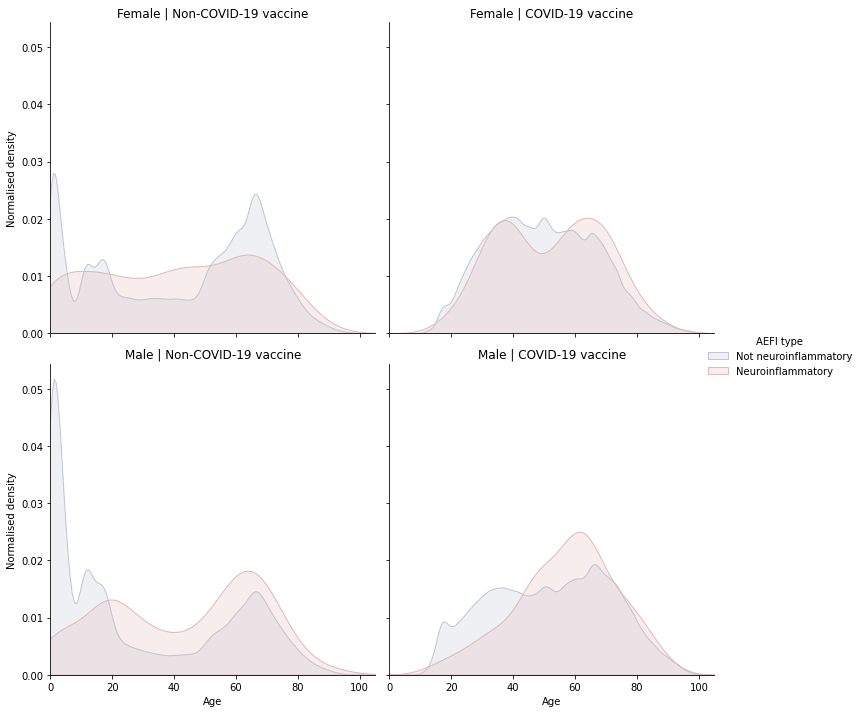

In [6]:
g = sns.FacetGrid(vaers_data[vaers_data.SEX.isin(("F", "M"))],
                  col="IS_COVID_VACCINE",
                  row="SEX",
                  hue="IS_NEUROINFLAMMATORY",
                  height=5,
                  aspect=1,
                  palette="vlag")

g.map(sns.kdeplot, "AGE_YRS", fill=True)
g.set_axis_labels("", "")

g.add_legend()

# Custom legend labels
g._legend.set_title("AEFI type")
new_labels = ("Not neuroinflammatory", "Neuroinflammatory")
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Custom grid labels
axes = g.axes.flatten()
axes[0].set_title("Female | Non-COVID-19 vaccine")
axes[1].set_title("Female | COVID-19 vaccine")
axes[2].set_title("Male | Non-COVID-19 vaccine")
axes[3].set_title("Male | COVID-19 vaccine")

axes[0].set(xlim=(0, 105))
axes[1].set(xlim=(0, 105))
axes[2].set(xlim=(0, 105))
axes[3].set(xlim=(0, 105))

g.set_axis_labels("Age", "Normalised density")


# Odds ratio analysis

## Contingency table

In [7]:
xt = pd.crosstab(vaers_data.IS_COVID_VACCINE, vaers_data.IS_NEUROINFLAMMATORY)

_d = xt.rename(index={0: "Non-COVID-19 vaccine", 1: "COVID-19 vaccine"},
               columns={0: "Non-neuroinflammatory AEFI", 1: "Neuroinflammatory AEFI"})

table = sm.stats.Table(_d.loc[:, ["Non-neuroinflammatory AEFI", "Neuroinflammatory AEFI"]])
table.table_orig

IS_NEUROINFLAMMATORY,Non-neuroinflammatory AEFI,Neuroinflammatory AEFI
IS_COVID_VACCINE,,
Non-COVID-19 vaccine,1203677,1908
COVID-19 vaccine,1322566,612


### Fitted expectation values

In [8]:
table.fittedvalues

IS_NEUROINFLAMMATORY,Non-neuroinflammatory AEFI,Neuroinflammatory AEFI
IS_COVID_VACCINE,,
Non-COVID-19 vaccine,1.204384e+06,1201.407249
COVID-19 vaccine,1.321859e+06,1318.592751


### Pearson residuals

In [9]:
table.resid_pearson

IS_NEUROINFLAMMATORY,Non-neuroinflammatory AEFI,Neuroinflammatory AEFI
IS_COVID_VACCINE,,
Non-COVID-19 vaccine,-0.643853,20.385626
COVID-19 vaccine,0.614577,-19.458701


### Fisher's exact test

In [10]:
odds_ratio, p_value = stats.fisher_exact(xt)

print(xt)
print(f"Odds ratio for association (Fisher's exact test): {odds_ratio} (p-value: {p_value})")

IS_NEUROINFLAMMATORY        0     1
IS_COVID_VACCINE                   
0                     1203677  1908
1                     1322566   612
Odds ratio for association (Fisher's exact test): 0.29192121638670443 (p-value: 1.7957717301608325e-181)


## Neuroinflammatory AEFIs' associations

In [11]:
tab = sm.stats.Table(pd.crosstab(vaers_data.IS_COVID_VACCINE, vaers_data.SYMPTOM).rename(
    index={0: "Non-COVID-19 vaccine", 1: "COVID-19 vaccine"})
                     )

pearson_residuals = tab.resid_pearson.T
actuals = tab.table_orig.T
expected = tab.fittedvalues.T

Bottom 5 by Pearson residuals (i.e. less frequent than expected for COVID-19 vaccines):

In [12]:
pearson_residuals.sort_values("COVID-19 vaccine").head(5)

IS_COVID_VACCINE,Non-COVID-19 vaccine,COVID-19 vaccine
SYMPTOM,,
No adverse event,179.120724,-170.998663
Incorrect product storage,129.875131,-123.986065
Product storage error,86.108586,-82.204073
Injection site erythema,70.751197,-67.543050
Expired product administered,62.133047,-59.315683


Top 5 by Pearson residuals (i.e. more frequent than expected for COVID-19 vaccines):

In [13]:
pearson_residuals.sort_values("COVID-19 vaccine").tail(5)

IS_COVID_VACCINE,Non-COVID-19 vaccine,COVID-19 vaccine
SYMPTOM,,
Nausea,-58.158325,55.521191
Dizziness,-62.581050,59.743371
Chills,-78.901769,75.324043
Fatigue,-84.697642,80.857107
Headache,-92.531427,88.335677


### Pearson residuals and expected-versus-actuals of neuroinflammatory disorders

In [14]:
pearson_residuals["IS_NEUROINFLAMMATORY"] = pearson_residuals.index.isin(NEUR_SYMPTOMS)
expected_versus_actual = \
    pearson_residuals[pearson_residuals.IS_NEUROINFLAMMATORY == True].sort_values("COVID-19 vaccine").join(
        expected[["COVID-19 vaccine"]], how="left", rsuffix="_expected").join(
            actuals[["COVID-19 vaccine"]], how="left", rsuffix="_actual")[["COVID-19 vaccine_expected", "COVID-19 vaccine_actual"]]

expected_versus_actual["SYMPTOM"] = expected_versus_actual.index

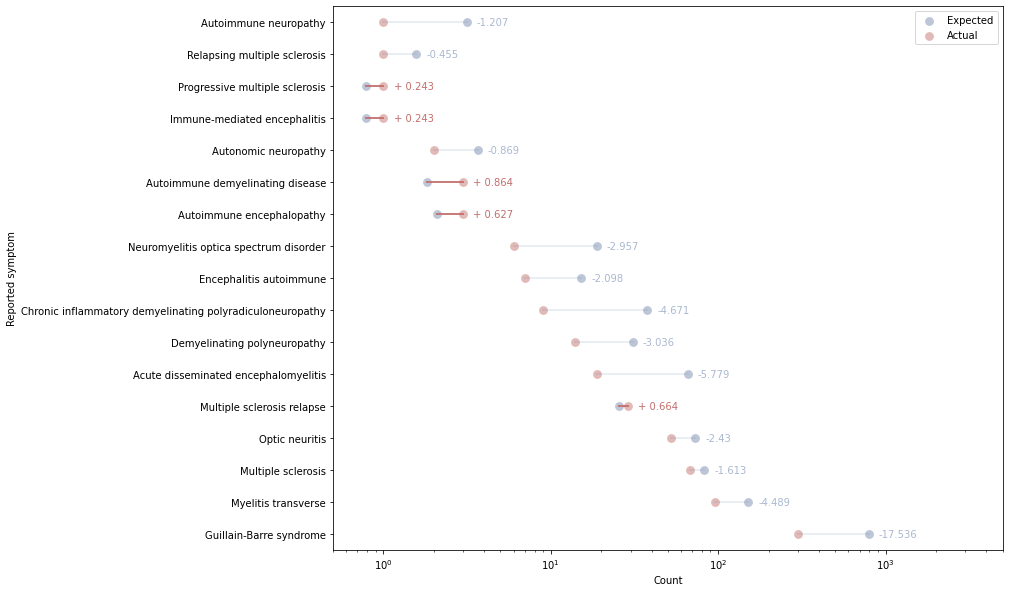

In [15]:
f, ax = plt.subplots(figsize=(12, 10))
ax.set_xscale("log")

data = expected_versus_actual[expected_versus_actual["COVID-19 vaccine_actual"] > 0]
sort_order = list(data["COVID-19 vaccine_actual"].sort_values().index)
data["more_than_expected"] = data["COVID-19 vaccine_actual"] > data["COVID-19 vaccine_expected"]

for idx, val in enumerate(sort_order):
    if data.loc[val, "more_than_expected"]:
        plt.plot([data.loc[val, "COVID-19 vaccine_actual"], data.loc[val, "COVID-19 vaccine_expected"]], [idx, idx],
                 linewidth=2, alpha=0.9, color=sns.color_palette("vlag")[-1])
    else:
        plt.plot([data.loc[val, "COVID-19 vaccine_actual"], data.loc[val, "COVID-19 vaccine_expected"]], [idx, idx],
                 linewidth=2, alpha=0.15, color=sns.color_palette("vlag")[0])

grid = sns.pointplot(x="count",
                     y="SYMPTOM",
                     hue="IS_COVID_VACCINE",
                     join=False,
                     jitter=False,
                     data=data.melt(id_vars=["SYMPTOM", "more_than_expected"], value_name="count"),
                     palette="vlag",
                     order=sort_order)

for idx, val in enumerate(sort_order):
    if data.loc[val, "more_than_expected"]:
        plt.text(data.loc[val, "COVID-19 vaccine_actual"] * 1.15, idx + 0.1,
                 f"+ {round(pearson_residuals.loc[val, 'COVID-19 vaccine'], 3)}", color=sns.color_palette("vlag")[-1])
    else:
        plt.text(data.loc[val, "COVID-19 vaccine_expected"] * 1.15, idx + 0.1,
                 f"{round(pearson_residuals.loc[val, 'COVID-19 vaccine'], 3)}", color=sns.color_palette("vlag")[1])

axes = grid.set(xlim=(5e-1, 5e3), xlabel="Count", ylabel="Reported symptom")

handles, labels = ax.get_legend_handles_labels()
grid.legend(handles=handles, labels=("Expected", "Actual"))


In [16]:
SHOW_VACCINES = ("COVID19", "MENB", "HPV4", "HPV9", "FLU3", "FLU4", "HEP", "VARZOS", "PNC13", "HEPAB")

In [17]:
p_normals = r".*negative$|.*\snormal$|.*(scopy|graphy|gram|metry|opsy)$|.*(count|percentage|level|test|assay|culture|X-ray|imaging|gradient|band(s)?|index|surface area|gas|scale|antibod(y|ies)|urine absent|Carotid pulse|partial pressure|time|P(C)?O2)$|Oxygen saturation$|End-tidal.*"
p_tests = r".*(ase|ose|ine|enzyme|in|ine|ines|ium|ol|ole|ate|lytes|ogen|gases|oids|ide|one|an|copper|iron)$|.*(level therapeutic)$|.*(globulin)\s.{1,2}$|Barium (swallow|enema)"
p_procedures = r".*(plasty|insertion|tomy|ery|puncture|therapy|treatment|tripsy|operation|repair|procedure|bypass|insertion|removal|graft|closure|implant|lavage|support|transplant|match|bridement|application|ablation)$|Incisional drainage$|.* stimulation$|Immunisation$"
p_normal_procedures = r"(Biopsy|pH|.* examination|X-ray|.* pulse|Blood|Electro(.*)gram|.* test(s)?|Echo(.*)gram|.*(scopy)|Cardiac (imaging|monitoring|ventriculogram)|Chromosomal|Carbohydrate antigen|Cell marker|.* examination|Computerised tomogram|Culture|.* evoked potential(s)?|Cytology|Doppler)(?!.*(abnormal|increased|decreased|depression|elevation|present|absent))"
p_managements = r"(Catheter|Device\).*|.* care$|.* user$|Cardiac pacemaker .*"
p_other_irrelevants = r"Blood group.*|Blood don(or|ation)$|Drug (abuse(r)?|dependence|screen).*|Elderly|Non-tobacco user|No adverse event"
p_covid_related = r".*COVID-19(prophylaxis|immunisation|screening)|Asymptomatic COVID-19"

p = re.compile("|".join([p_normals, p_tests, p_procedures, p_normal_procedures, p_other_irrelevants, p_covid_related]))

In [18]:
xt_by_symptom = pd.crosstab(vaers_data.VAX_TYPE, vaers_data.SYMPTOM)
columns_to_keep = [x for x in list(xt_by_symptom.columns) if not p.match(x)]
xt_by_symptom = xt_by_symptom[columns_to_keep]

In [19]:

odds_ratios_by_symptom = pd.DataFrame(columns=xt_by_symptom.columns,
                                      index=xt_by_symptom.index)

symptom_sums = xt_by_symptom.sum(axis=0)
vax_sums = xt_by_symptom.sum(axis=1)
xt_by_symptom_total = xt_by_symptom.sum().sum()

vax_iterator = tqdm(xt_by_symptom.index)

for vaccine in vax_iterator:
    vax_iterator.set_description(f"Processing: {vaccine}")
    for symptom in tqdm(xt_by_symptom.columns, leave=False):
        a = xt_by_symptom.loc[vaccine, xt_by_symptom.columns == symptom].sum()
        b = vax_sums[vaccine] - a
        c = symptom_sums[symptom] - a
        d = xt_by_symptom_total - a - b - c

        OR = (a * d) / (c * b) if c * b > 0 else np.nan
        odds_ratios_by_symptom.loc[vaccine, symptom] = OR

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

  0%|          | 0/7426 [00:00<?, ?it/s]

In [20]:
odds_ratios_by_symptom.to_csv("odds_ratios_by_symptom.csv")

In [21]:
odds_ratios_by_symptom["VACCINE_TYPE"] = odds_ratios_by_symptom.index
odds_ratios_melted = odds_ratios_by_symptom.melt(id_vars="VACCINE_TYPE", value_name="OR")
odds_ratios_melted["IS_NEUROINFLAMMATORY"] = odds_ratios_melted["SYMPTOM"].isin(NEUR_SYMPTOMS)

In [22]:
odds_ratios_melted = odds_ratios_melted[
    (odds_ratios_melted.VACCINE_TYPE.isin(SHOW_VACCINES) & (odds_ratios_melted.IS_NEUROINFLAMMATORY == True))]

Text(0, 0.5, 'Vaccine type')

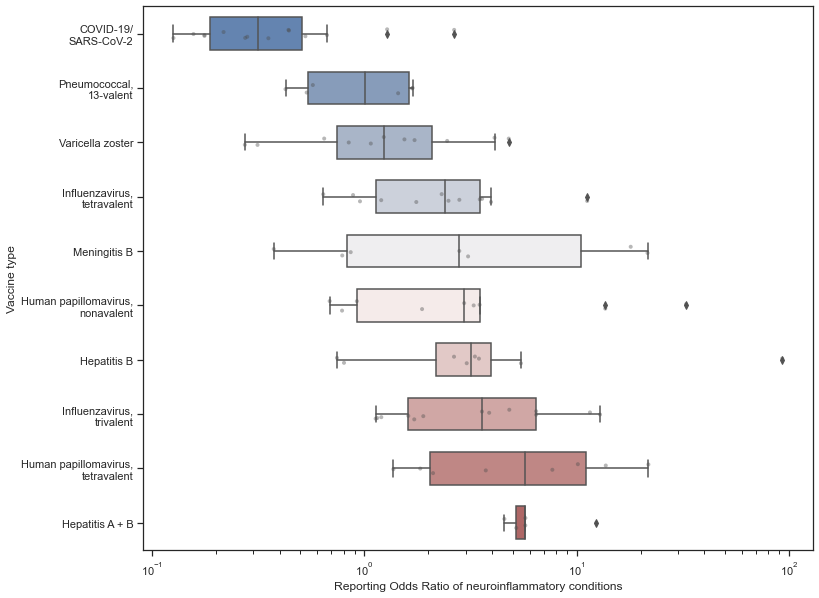

In [23]:
sns.set_theme(style="ticks")

vaccine_type_names = {"COVID19": "COVID-19/\nSARS-CoV-2",
                      "PNC13": "Pneumococcal,\n13-valent",
                      "VARZOS": "Varicella zoster",
                      "FLU4": "Influenzavirus,\ntetravalent",
                      "MENB": "Meningitis B",
                      "HPV9": "Human papillomavirus,\nnonavalent",
                      "HEP": "Hepatitis B",
                      "FLU3": "Influenzavirus,\ntrivalent",
                      "HPV4": "Human papillomavirus,\ntetravalent",
                      "HEPAB": "Hepatitis A + B"}

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(12, 10))
ax.set_xscale("log")

# Create ordering

order_by_mean_OR = odds_ratios_melted.replace(0, np.nan).replace({"VACCINE_TYPE": vaccine_type_names}).groupby(by=["VACCINE_TYPE"])[
    "OR"].median().sort_values(ascending=False).iloc[::-1].index

# Initialize the figure with a logarithmic x axis

sns.boxplot(data=odds_ratios_melted.replace(0, np.nan).replace({"VACCINE_TYPE": vaccine_type_names}),
            y="VACCINE_TYPE",
            x="OR",
            palette="vlag",
            width=.6,
            order=order_by_mean_OR)

sns.stripplot(data=odds_ratios_melted.replace(0, np.nan).replace({"VACCINE_TYPE": vaccine_type_names}),
              y="VACCINE_TYPE",
              x="OR",
              size=4,
              color=".3",
              alpha=0.4,
              linewidth=0,
              order=order_by_mean_OR)

plt.xlabel("Reporting Odds Ratio of neuroinflammatory conditions")
plt.ylabel("Vaccine type")

